# Modeling with Time Series Analysis
# Using saas.csv or log data from API usage or store_item_sales

In [6]:
import Prepare

import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pandas.plotting import register_matplotlib_converters

import statsmodels.api as sm
from statsmodels.tsa.api import Holt

import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_csv('sales_joined_df.csv', index_col=0)

In [8]:
df = Prepare.set_index(df, 'sale_date')

In [9]:
df.head()

,sale_amount,sale_id,store_address,store_city,store_id,store_state,store_zipcode,item_brand,item_id,item_name,item_price,item_upc12,item_upc14
sale_date,,,,,,,,,,,,,
2013-01-01 00:00:00+00:00,13.0,1,12125 Alamo Ranch Pkwy,San Antonio,1,TX,78253,Riceland,1,Riceland American Jazmine Rice,0.84,35200264013,35200264013
2013-01-01 00:00:00+00:00,14.0,118691,1015 S WW White Rd,San Antonio,6,TX,78220,Twinings Of London,7,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,70177154004,70177154004
2013-01-01 00:00:00+00:00,29.0,350593,2118 Fredericksburg Rdj,San Antonio,3,TX,78201,Usda Produce,20,Plums Black,5.62,204040000000,204040000000
2013-01-01 00:00:00+00:00,21.0,116865,1520 Austin Hwy,San Antonio,5,TX,78218,Twinings Of London,7,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,70177154004,70177154004
2013-01-01 00:00:00+00:00,26.0,115039,516 S Flores St,San Antonio,4,TX,78204,Twinings Of London,7,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,70177154004,70177154004


## 1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.

In [10]:
train_index = int(len(df) * .7)
print("Index to split for 70/30 train/test:",train_index)

Index to split for 70/30 train/test: 255639


In [11]:
train = df[:train_index]
test = df[train_index:]

In [12]:
print("Is train + test = df?")
print((len(train)+len(test))==len(df))

Is train + test = df?
True


Text(0, 0.5, 'sale_amount')

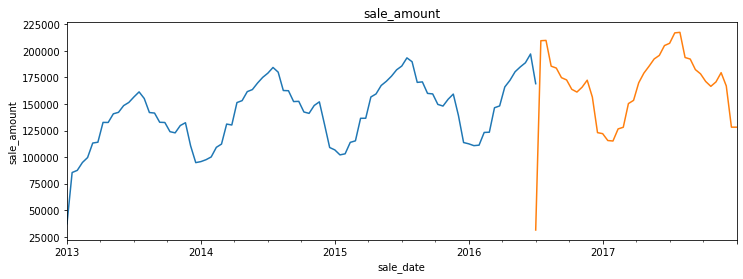

In [13]:
plt.figure(figsize=(12,4))
train['sale_amount'].resample('2W').sum().plot()
test['sale_amount'].resample('2W').sum().plot()
plt.title('sale_amount')
plt.ylabel('sale_amount')

Text(0, 0.5, 'item_price')

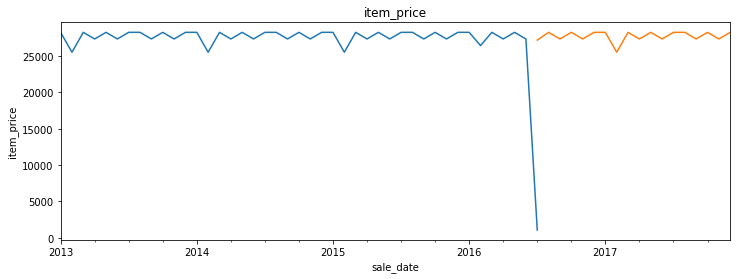

In [14]:
plt.figure(figsize=(12,4))
train['item_price'].resample('M').sum().plot()
test['item_price'].resample('M').sum().plot()
plt.title('item_price')
plt.ylabel('item_price')

In [15]:
df = df.groupby(['sale_date'])[['sale_amount','item_price']].sum()

In [16]:
df

,sale_amount,item_price
sale_date,,
2013-01-01 00:00:00+00:00,5570.0,912.0
2013-01-02 00:00:00+00:00,5531.0,912.0
2013-01-03 00:00:00+00:00,5881.0,912.0
2013-01-04 00:00:00+00:00,6480.0,912.0
2013-01-05 00:00:00+00:00,6672.0,912.0
...,...,...
2017-12-27 00:00:00+00:00,8428.0,912.0
2017-12-28 00:00:00+00:00,9011.0,912.0
2017-12-29 00:00:00+00:00,9621.0,912.0


# Functions for Modeling

In [17]:
def make_predictions():
    yhat_df = pd.DataFrame({'sale_amount': [amount],
                            'item_price': [price],
                           }, index = train.index)
    return yhat_df

In [18]:
def evaluate(target_var):
    rmse = round(sqrt(mean_squared_error(train[target_var], yhat_df[target_var])), 0)
    return rmse

In [19]:
def plot_and_eval(target_var):
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

In [20]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])

# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## 2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
- Simple Average
- Moving Average
- Holt's Linear Trend Model
- Based on previous year/month/etc., this is up to you.

## simple average

In [21]:
amount = round(train['sale_amount'].mean(), 2)
price = round(train['item_price'].mean(), 2)

In [22]:
yhat_df = make_predictions()

In [23]:
yhat_df.head(3)

,sale_amount,item_price
sale_date,,
2013-01-01 00:00:00+00:00,50.94,4.56
2013-01-01 00:00:00+00:00,50.94,4.56
2013-01-01 00:00:00+00:00,50.94,4.56


sale_amount -- RMSE: 28


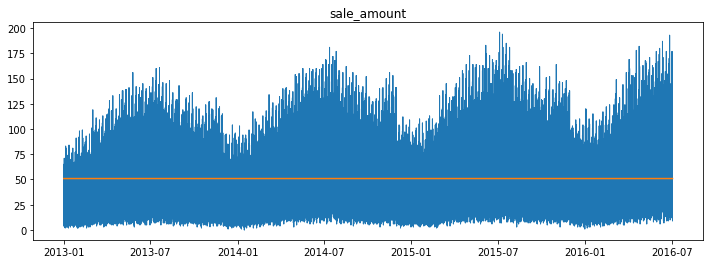

item_price -- RMSE: 3


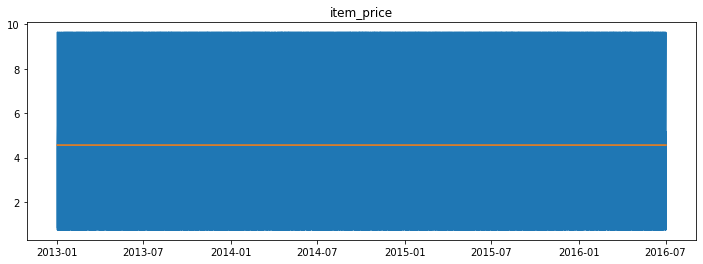

In [24]:
plot_and_eval('sale_amount')
plot_and_eval('item_price')

In [25]:
eval_df = append_eval_df('simple_average', 'sale_amount')
eval_df = append_eval_df('simple_average', 'item_price')

## Moving Average

In [26]:
# compute a 14 day rolling average, for sale amount
# compute a 30 day rolling average 
# use the most recent/last moving day period value to predict forward. 

period_amount = 14
period_price = 30

amount = round(train['sale_amount'].rolling(period_amount).mean().iloc[-1], 2)
price = round(train['item_price'].rolling(period_price).mean().iloc[-1], 2)

yhat_df = make_predictions()
yhat_df.head(3)

,sale_amount,item_price
sale_date,,
2013-01-01 00:00:00+00:00,74.57,3.62
2013-01-01 00:00:00+00:00,74.57,3.62
2013-01-01 00:00:00+00:00,74.57,3.62


sale_amount -- RMSE: 37


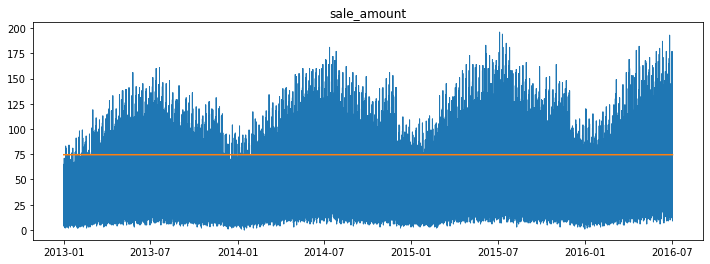

item_price -- RMSE: 3


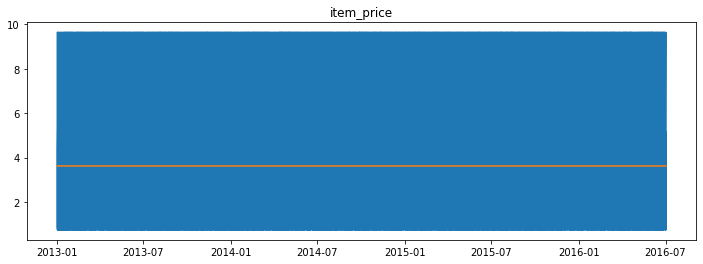

In [27]:
plot_and_eval('sale_amount')
plot_and_eval('item_price')

In [28]:
eval_df = append_eval_df('moving_average', 'sale_amount')
eval_df = append_eval_df('moving_average', 'item_price')

# Full modeling done on Fitbit data in notebook titled Model_Fitbit.ipynb